In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from cpyment import CModel

In [147]:
# Parameters

# These are taken from the Ile de France model
eps = 1.0/3.7   # Latency period
mu = 1.0/3.8    # Infectious period
R0 = 3

# We then deduce the infectiousness
beta = R0*mu

# Lockdown suppression factor
suppr = 1.0

# Testing
r = 0.97   # Recall (true positives per positive)
s = 0.95   # Specificity (true negatives per negative)
tf = 0.0  # Fraction tested per day
tIf = 0.0 # Additional likelihood of being tested if infected

# Contact tracing
n = 0.0 # Average number of contacts
delta = 2.0 # Delay/number of days for each round of contact tracing

# Quarantine
qrate = 1.0/14.0   # Duration: two weeks
betaf_QNQ = 0.0    # Fraction of beta for Q-NQ contacts (high for imperfect isolation)
betaf_QQ = 0.0     # Fraction of beta for Q-Q contacts (high for group quarantine)

In [148]:
cm = CModel(['S', 'E', 'I', 'R', 'QS', 'QE', 'QI', 'QR'])

# Infection processes
cm.set_coupling_rate('S*I:S=>E', suppr*beta, 'beta')
cm.set_coupling_rate('S*QI:S=>E', suppr*beta*betaf_QNQ, 'beta_NQQ')
cm.set_coupling_rate('QS*I:QS=>QE', suppr*beta*betaf_QNQ, 'beta_QNQ')
cm.set_coupling_rate('QS*QI:QS=>QE', suppr*beta*betaf_QQ, 'beta_QQQ')

# Evolution of the disease
cm.set_coupling_rate('E:E=>I', eps, 'eps')
cm.set_coupling_rate('QE:QE=>QI', eps, 'epsQ')
cm.set_coupling_rate('I:I=>R', mu, 'mu')
cm.set_coupling_rate('QI:QI=>R', eps, 'muQ')

# Testing
cm.set_coupling_rate('S:S=>QS', tf*(1-s), 'tqS')
cm.set_coupling_rate('E:E=>QE', tf*r, 'tqE')
cm.set_coupling_rate('I:I=>QI', (tf+tIf)*r, 'tqI')
cm.set_coupling_rate('R:R=>QR', tf*(1-s), 'tqR')

# Contact tracing
for Q in ['QS', 'QE', 'QI', 'QR']:
    for X in ['S', 'E', 'I', 'R']:
        rate = n/delta*(r if X in 'EI' else (1-s))
        cm.set_coupling_rate('{0}*{1}:{0}=>Q{0}'.format(X, Q), rate)

# Quarantine
cm.set_coupling_rate('QS:QS=>S', qrate, 'exitqS')
cm.set_coupling_rate('QR:QR=>R', qrate, 'exitqR')

In [149]:
t = np.linspace(0, 90, 1000)

e0 = 0.01
y0 = np.zeros(8)
y0[0] = 1-e0
y0[1] = e0

traj = cm.integrate(t, y0)

<IPython.core.display.Javascript object>


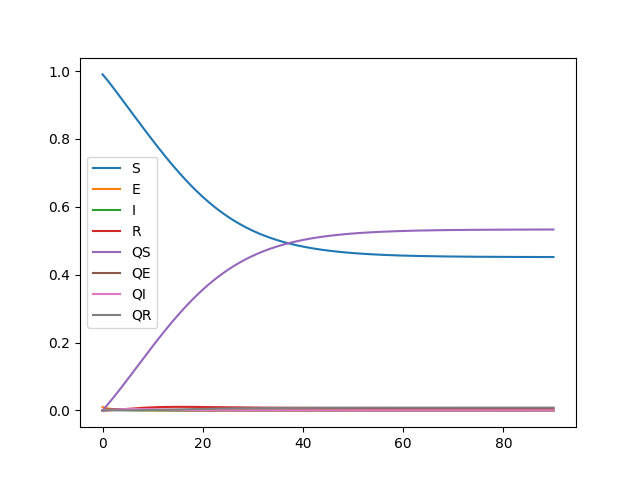

In [150]:
fig, ax = plt.subplots()

for i, sname in enumerate(cm.states):
    ax.plot(t, traj['y'][:,i], label=sname)
    
ax.legend()